**EXECUTE O BLOCO ABAIXO PARA CARREGAR TODAS AS FERRAMENTAS NECESSÁRIAS.**

In [ ]:
# Instalando a versão mais recente do TensorFlow.
!pip install tensorflow # Biblioteca para aprendizado de máquina e redes neurais.

# Importando todas as bibliotecas necessárias.
import pandas as pd # Manipulacao e análise de dados, DataFrames, processar planilhas.
import numpy as np  # Operacoes matemáticas e manipulacao de arrays.

# Ferramentas para aprendizagem de máquina.
from sklearn.model_selection import train_test_split # Divide o conjunto de dados em treinamento e teste.
from sklearn.preprocessing import StandardScaler     # Normaliza os dados para melhorar o desempenho do modelo, ajustando-os para uma média de 0 e variância de 1.
from sklearn.preprocessing import LabelEncoder       # Converte rótulos de texto em valores numéricos.
from sklearn.metrics import confusion_matrix         # Avaliar o desempenho do modelo atráves da matriz de confusão.

# API que roda no TensorFlow para trabalhar com RNAs.
from keras.utils import to_categorical    # Converte rótulos numéricos em uma codificação categórica (one-hot encoding).
from keras.models import Sequential       # Permite construir um modelo empilhando camadas de forma sequencial.
from keras.layers import Dense            # Permite adicionar uma camada completamente conectada à rede neural.
from keras.optimizers import Adam         # Permite utilizar um otimizador Adam que ajusta os pesos da rede para minimizar o erro.
from keras.callbacks import EarlyStopping # Permite interromper o treinamento automaticamente quando o desempenho não melhora, prevenindo o overfitting.
import matplotlib.pyplot as plt           # Visualização de dados para gráficos.
from google.colab import files            # Permite carregar e baixar arquivos no ambiente do Colab.
import seaborn as sns                     # Facilita a visualização de gráficos junto com o Matplotlib.

**EXECUTE O CÓDIGO ABAIXO PARA SELECIONAR OS ARQUIVOS DE TREINAMENTO, TESTE E PESOS DE CADA SINTOMA. CLIQUE EM 'CHOOSE FILES' E SELECIONE TODOS OS RESPECTIVOS ARQUIVOS NA BASE DE DADOS UTILIZADA QUE SE ENCONTRA NA PASTA 'BASE DE DADOS UTILIZADA'.**

In [ ]:
# Carregando os datasets de treinamento, teste e pesos para a severidade dos sintomas.
uploaded = files.upload()

data_train = pd.read_csv('Training-Classificado.csv', delimiter=';') # Treinamento.
data_test = pd.read_csv('Testing-Classificado.csv', delimiter=';')   # Teste.
severity_data = pd.read_csv('Symptom-Severity.csv', delimiter=';')   # Pesos dos Sintomas.

# Normalizando os nomes das colunas de cada dataset (removendo espaços em branco extras do inicio e fim).
data_train.columns = data_train.columns.str.strip()
data_test.columns = data_test.columns.str.strip()
severity_data.columns = severity_data.columns.str.strip()

Saving Dataset.csv to Dataset.csv
Saving Disease_Classes.csv to Disease_Classes.csv
Saving Disease_Precaution.csv to Disease_Precaution.csv
Saving Symptom-Severity.csv to Symptom-Severity.csv
Saving Testing-Classificado.csv to Testing-Classificado.csv
Saving Training-Classificado.csv to Training-Classificado.csv


In [ ]:
# Exibindo informações sobre os DataFrames carregados.
print("Informações sobre o DataFrame de Treinamento:")
print(data_train.info())
print("\nInformações sobre o DataFrame de Teste:")
print(data_test.info())
print("\nInformações sobre o DataFrame de Severidade:")
print(severity_data.info())

Informações sobre o DataFrame de Treinamento:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306 entries, 0 to 305
Columns: 135 entries, abdominal_pain to prognosis
dtypes: int64(134), object(1)
memory usage: 322.9+ KB
None

Informações sobre o DataFrame de Teste:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42 entries, 0 to 41
Columns: 135 entries, abdominal_pain to prognosis
dtypes: int64(134), object(1)
memory usage: 44.4+ KB
None

Informações sobre o DataFrame de Severidade:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 134 entries, 0 to 133
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Symptom   134 non-null    object
 1   Severity  134 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 2.2+ KB
None


**EXECUTE O BLOCO ABAIXO PARA AJUSTAR E NORMALIZAR OS DATAFRAMES CARREGADOS. OS COMENTÁRIOS EXPLICAM O FUNCIONAMENTO PASSO A PASSO.**

In [ ]:
# Extraindo os nomes dos sintomas e os pesos correspondentes em um dicionário.
# As chaves são os sintomas e os valores são os respectivos pesos.
weights_dict = dict(zip(severity_data['Symptom'], severity_data['Severity']))

# Extraindo em variáveis independentes a coluna dos sintomas e diganósticos para o arquivo de treinamento.
X_train = data_train.drop('prognosis', axis=1)  # features (sintomas).
y_train = data_train['prognosis']               # target (diagnósticos).

# Extraindo em variáveis independentes a coluna dos sintomas e diganósticos para o arquivo de treinamento.
X_test = data_test.drop('prognosis', axis=1)  # features (sintomas).
y_test = data_test['prognosis']               # target (diagnósticos).

# Faz uma cópia para não sobrescrever os dados originais com a multiplicacao dos sintomas pelos seus respectivos pesos.
X_train_weighted = X_train.copy()
X_test_weighted = X_test.copy()

# Multiplicando apenas os sintomas presentes (valor 1 na planilha) nos arquivos de treinamento e teste pelos seus respectivos pesos.
for symptom in weights_dict.keys():
    # Treinamento.
    if symptom in X_train_weighted.columns:
        X_train_weighted[symptom] *= weights_dict[symptom]
    # Teste.
    if symptom in X_test_weighted.columns:
        X_test_weighted[symptom] *= weights_dict[symptom]

# Normalizando os dados de teste e treinamento ponderados para que todos fiquem em uma escala semelhante.
scaler = StandardScaler()                                             # Ajusta os dados para uma média de 0 e desvio padrão de 1. Coloca os sintomas em uma escala comparável.
X_train_weighted_normalized = scaler.fit_transform(X_train_weighted)  # Calcular e aplicar a normalização ao conjunto de treinamento.
X_test_weighted_normalized = scaler.transform(X_test_weighted)        # Calcular e aplicar a normalização ao conjunto de teste.

**EXECUTE O CÓDIGO ABAIXO PARA REALIZAR A CODIFICACAO ONE-HOT ENCONDING. OS COMENTÁRIOS EXPLICAM PASSO A PASSO O FUNCIONAMENTO.**

In [ ]:
# Convertendo os rótulos de saída (diagnósticos) string dos dataframes de treinamento e teste para one-hot encoding.
# Garante que os rótulos estejam em um formato adequado para o modelo de redes neurais.
# O one-hot encoding é útil para classificar corretamente o diagnóstico pois transforma o problema em uma tarefa de classificação multiclasse.

label_encoder = LabelEncoder()                          # Classe para transformar os textos (nomes das classes) em valores numéricos.
y_train_encoded = label_encoder.fit_transform(y_train)  # Converte cada rótulo (classes no dataframe de treinamento) para um número inteiro único em uma lista.
y_test_encoded = label_encoder.transform(y_test)        # Converte cada rótulo (classes no dataframe de teste) para um número inteiro único em uma lista.

# Converter para one-hot encoding (útil para classificacao onde cada diagnóstico tem sua posicao única na saída).
num_classes = len(label_encoder.classes_) # Conta o número de classes (diagnósticos) detectadas nos conjuntos de dados (teste e treinamento).

# Definindo a dimensao do vetor one-hot. Contém 1 na posicao correspondente a classe e 0 nas demais posicoes.
y_train_onehot = to_categorical(y_train_encoded, num_classes=num_classes)
y_test_onehot = to_categorical(y_test_encoded, num_classes=num_classes)

# Exibindo as classes e seus valores one-hot correspondentes.
print("Classes e seus valores one-hot:")
# Para cada classe (usando o índice idx) do total de classes cria um vetor one-hot correspondente.
for idx, class_name in enumerate(label_encoder.classes_):
    one_hot_vector = to_categorical([idx], num_classes=num_classes)[0]
    print(f"{class_name}: {one_hot_vector}")

Classes e seus valores one-hot:
Classe 1: [1. 0. 0. 0. 0. 0. 0. 0. 0.]
Classe 2: [0. 1. 0. 0. 0. 0. 0. 0. 0.]
Classe 3: [0. 0. 1. 0. 0. 0. 0. 0. 0.]
Classe 4: [0. 0. 0. 1. 0. 0. 0. 0. 0.]
Classe 5: [0. 0. 0. 0. 1. 0. 0. 0. 0.]
Classe 6: [0. 0. 0. 0. 0. 1. 0. 0. 0.]
Classe 7: [0. 0. 0. 0. 0. 0. 1. 0. 0.]
Classe 8: [0. 0. 0. 0. 0. 0. 0. 1. 0.]
Classe 9: [0. 0. 0. 0. 0. 0. 0. 0. 1.]


**EXECUTE O CÓDIGO ABAIXO PARA REALIZAR A INSTÂNCIA DA MLP, TREINAMENTO E TESTE NA CONFIGURACAO PADRÃO.**

**HIPER PARÂMETROS QUE PODEM SER AJUSTADOS:**
1.   **HIDDEN_NEURONS**
2.   **ACTIVATION**
3.   **OPTIMIZER**
4.   **LEARNING_RATE**
5.   **LOSS**
6.   **METRICS**
7.   **EPOCS**
8.   **BATCH_SIZE**

**OS COMENTÁRIOS EXPLICAM EM DETALHE O FUNCIONAMENTO DA REDE E TODOS OS SEUS PARÂMETROS.**


In [ ]:
# RNA MLP

# Definir o número de entradas, camadas ocultas e saídas.
input_dim = X_train_weighted.shape[1] # Número de características (sintomas) no conjunto de dados de treinamento.
hidden_neurons = 72                   # Número de neurônios na camada oculta.
output_neurons = 9                    # Número de neurônios na camada de saída (9 classes). Cada um representa a probabilidade de uma classe específica.

# Construindo o modelo MLP Sequencial do Keras.
# As camadas da RNA são adicionadas em sequência.
model = Sequential()

# Construindo: Camada de entrada -> camada oculta.
model.add(Dense(hidden_neurons, input_dim=input_dim, activation='relu')) # Número de neurônios da camada oculta, Número de entradas, Funcao de ativacao.

# Construindo: Camada de saída.
model.add(Dense(output_neurons, activation='softmax')) # Número de neurônios da camada de saída, Funcao de ativacao.

# Compilar o modelo.
model.compile(optimizer=Adam(learning_rate=0.001),  # Otimizador para ajustar os pesos da rede e minimizar o erro. Taxa de aprendizado para controlar o quanto os pesos mudam a cada passo.
              loss='categorical_crossentropy',      # Funcao de perda para classificacao multiclasse que calcula o erro entre as saídas previstas.
              metrics=['accuracy'])                 # Define a métrica a ser monitorada, no caso, acurácia da classificacao.

# Previne o overfitting, interrompe o treinamento quando o modelo apresenta piora na perda de validacao (val_loss).
early_stopping = EarlyStopping(monitor='val_loss',        # Observa a perda de validacao.
                               patience=5,                # Define o número de épocas consecutivas sem melhora no val_loss buscando melhorar por 5 épocas adicionais antes de parar.
                               restore_best_weights=True) # Restaura os melhores pesos no conjunto de validacao.

# Treinar o modelo com os dados ponderados e normalizados.
history = model.fit(X_train_weighted_normalized, y_train_onehot,                  # Sintomas ponderados normalizados e Rótulos de sáida no formato one-hot (Conjunto de treinamento).
                    epochs=15,                                                    # Número máximo de épocas (passagem completa pelo conjunto de dados).
                    batch_size=4,                                                 # Tamanho do lote (total de amostras processadas antes de atualizar os pesos do modelo).
                    validation_data=(X_test_weighted_normalized, y_test_onehot))  # Dados de validacao para avaliar o desempenho do modelo (Conjunto de teste: sintomas e rótulos de saída).

Epoch 1/15


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.3068 - loss: 2.1037 - val_accuracy: 0.8571 - val_loss: 0.6528
Epoch 2/15
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9043 - loss: 0.5264 - val_accuracy: 0.9762 - val_loss: 0.2106
Epoch 3/15
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9794 - loss: 0.2269 - val_accuracy: 1.0000 - val_loss: 0.0866
Epoch 4/15
77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9899 - loss: 0.1276 - val_accuracy: 1.0000 - val_loss: 0.0415
Epoch 5/15
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 0.0647 - val_accuracy: 1.0000 - val_loss: 0.0239
Epoch 6/15
77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 1.0000 - loss: 0.0545 - val_accuracy: 1.0000 - val_loss: 0.0141
Epoch 7/15
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.0000 - loss: 0.0352 - val_accuracy: 1.0000 - val_loss: 0.0094
Epoch 8/15
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.0000 - loss: 0.0261 - val_accuracy: 1.0000 - val_loss: 0.0068
Epo

In [ ]:
model.save("RNA_MLP.h5")

**EXECUTE O BLOCO ABAIXO PARA REALIZAR A AVALIACAO DO MODELO TREINADO. OS COMENTÁRIOS EXPLICAM O FUNCIONAMENTO.**

In [ ]:
# Avaliar o desempenho do modelo.

# Função do Keras que calcula a perda e a precisão do modelo, usando os dados de teste.
test_loss, test_acc = model.evaluate(X_test_weighted, y_test_onehot) # Sintomas e Rótulos de sáida one-hot (Conjunto de teste).

print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test Loss: {test_loss:.4f}")

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 0.0905 
Test Accuracy: 1.0000
Test Loss: 0.0917


**A BAIXO TEMOS A MATRIZ DE CONFUSÃO. OS COMENTÁRIOS EXPLICAM COMO FUNCIONA A IMPLEMENTACAO E INTERPRETACAO DOS DADOS.**

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


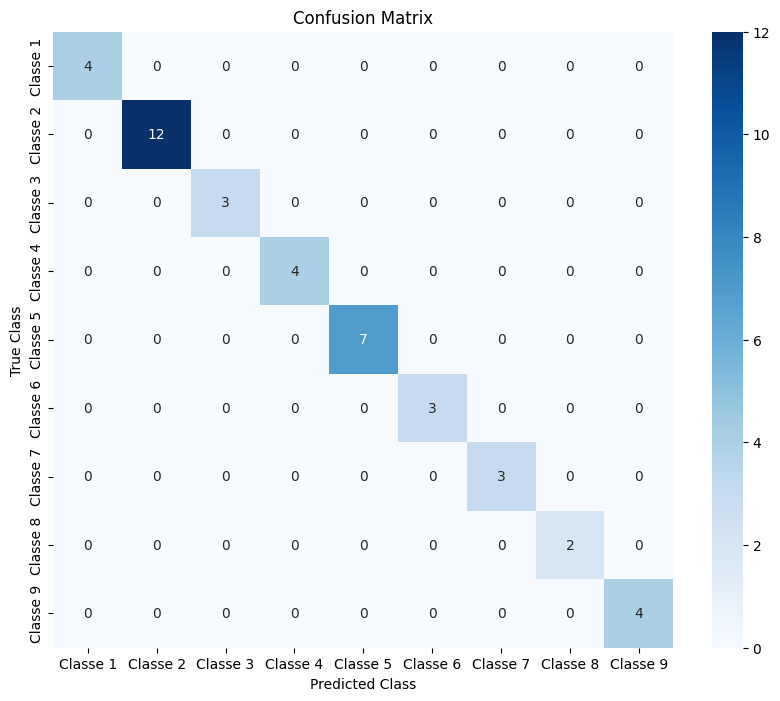

In [ ]:
# Gerar a matriz de confusão comparando as classes verdadeiras com as classes previstas para o conjunto de teste.

true_classes = np.argmax(y_test_onehot, axis=1)     # Converte os rótulos verdadeiros (em formato one-hot) para índices numéricos das classes originais.
predictions = model.predict(X_test_weighted)        # Usa o modelo treinado para prever as classes do conjunto de teste X_test_weighted. A saída é uma matriz de probabilidades para cada amostra.
predicted_classes = np.argmax(predictions, axis=1)  # Converte a matriz de probabilidades das predições em índices das classes previstas, identificando o índice da classe com a maior probabilidade para cada exemplo de teste.

# Cria uma matriz de confusão usando as classes verdadeiras (true_classes) e as classes previstas pelo modelo (predicted_classes).
# As linhas representam as classes verdadeiras.
# As colunas representam as classes previstas.
# Os valores corretos se correspondem na diagonal principal.
conf_matrix = confusion_matrix(true_classes, predicted_classes)

# Visualizar a matriz de confusão.
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted Class')
plt.ylabel('True Class')
plt.title('Confusion Matrix')
plt.show()

**ABAIXO TEMOS UMA FORMA DE CALCULAR MANUALMENTE A ACURÁCIA DO MODELO COM OS DADOS DE TESTE. OS COMENTÁRIOS EXPLICAM EM DETALHES COMO FUNCIONA.**

In [ ]:
# Calculo manual da acurácia do modelo com os dados de teste.

# Usa o modelo para fazer predições com os dados de teste X_test.
# O resultado, predictions, é uma matriz de probabilidades, onde cada linha contém as probabilidades de uma amostra pertencer a cada uma das classes.
predictions = model.predict(X_test)
predicted_classes = np.argmax(predictions, axis=1)  # Converte as probabilidades previstas em classes. np.argmax retorna o índice da classe com a maior probabilidade para cada exemplo, que é o rótulo da classe prevista pelo modelo para essa amostra.
true_classes = np.argmax(y_test_onehot, axis=1)     # Converte os rótulos de saída y_test_onehot do formato one-hot para índices numéricos das classes reais (ou "verdadeiras").

correct_predictions = np.sum(predicted_classes == true_classes) # Conta o número de predições corretas.
total_predictions = len(true_classes)                           # Define o número total de amostras no conjunto de teste.
accuracy = correct_predictions / total_predictions              # Calcula a acurácia dividindo o número de predições corretas (correct_predictions) pelo número total de predições (total_predictions). Esse valor representa a fração de amostras do conjunto de teste que foram classificadas corretamente.

print(f"Acurácia no conjunto de teste: {accuracy:.4f}")

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
Acurácia no conjunto de teste: 1.0000


**ABAIXO SEGUE UMA FORMA MANUAL DE TESTAR A REDE, INSERINDO OS SINTOMAS DE FORMA SEPARADA, É UMA SIMULACAO DO QUE SERÁ FEITO NA APLICACAO WEB EM QUE A RNA MLP SERÁ UTILIZADA.**

In [ ]:
# Defina um dicionário com os pesos dos sintomas (este deve ser o mesmo usado na API).
weights_dict = {
    'abdominal_pain': 4,
    'abnormal_menstruation': 6,
    'acidity': 3,
    'acute_liver_failure': 6,
    'altered_sensorium': 2,
    'anxiety': 4,
    'back_pain': 3,
    'belly_pain': 4,
    'blackheads': 2,
    'bladder_discomfort': 4,
    'blister': 4,
    'blood_in_sputum': 5,
    'bloody_stool': 5,
    'blurred_and_distorted_vision': 5,
    'breathlessness': 4,
    'brittle_nails': 5,
    'bruising': 4,
    'burning_micturition': 6,
    'chest_pain': 7,
    'chills': 3,
    'cold_hands_and_feet': 5,
    'coma': 7,
    'congestion': 5,
    'constipation': 4,
    'continuous_feel_of_urine': 6,
    'continuous_sneezing': 4,
    'cough': 4,
    'cramps': 4,
    'dark_urine': 4,
    'dehydration': 4,
    'depression': 3,
    'diarrhoea': 6,
    'dischromic_patches': 6,
    'distention_of_abdomen': 4,
    'dizziness': 4,
    'drying_and_tingling_lips': 4,
    'enlarged_thyroid': 6,
    'excessive_hunger': 4,
    'extra_marital_contacts': 5,
    'family_history': 5,
    'fast_heart_rate': 5,
    'fatigue': 4,
    'fluid_overload': 6,
    'fluid_overload': 4,
    'foul_smell_of_urine': 5,
    'headache': 3,
    'high_fever': 7,
    'hip_joint_pain': 2,
    'history_of_alcohol_consumption': 5,
    'increased_appetite': 5,
    'indigestion': 5,
    'inflammatory_nails': 2,
    'internal_itching': 4,
    'irregular_sugar_level': 5,
    'irritability': 2,
    'irritation_in_anus': 6,
    'itching': 1,
    'joint_pain': 3,
    'knee_pain': 3,
    'lack_of_concentration': 3,
    'lethargy': 2,
    'loss_of_appetite': 4,
    'loss_of_balance': 4,
    'loss_of_smell': 3,
    'loss_of_taste': 5,
    'malaise': 6,
    'mild_fever': 5,
    'mood_swings': 3,
    'movement_stiffness': 5,
    'mucoid_sputum': 4,
    'muscle_pain': 2,
    'muscle_wasting': 3,
    'muscle_weakness': 2,
    'nausea': 5,
    'neck_pain': 5,
    'nodal_skin_eruptions': 4,
    'obesity': 4,
    'pain_behind_the_eyes': 4,
    'pain_during_bowel_movements': 5,
    'pain_in_anal_region': 6,
    'painful_walking': 2,
    'palpitations': 4,
    'passage_of_gases': 5,
    'patches_in_throat': 6,
    'phlegm': 5,
    'polyuria': 4,
    'prominent_veins_on_calf': 6,
    'puffy_face_and_eyes': 5,
    'pus_filled_pimples': 2,
    'receiving_blood_transfusion': 5,
    'receiving_unsterile_injections': 2,
    'red_sore_around_nose': 2,
    'red_spots_over_body': 3,
    'redness_of_eyes': 5,
    'restlessness': 5,
    'runny_nose': 5,
    'rusty_sputum': 4,
    'scurrying': 2,
    'shivering': 5,
    'silver_like_dusting': 2,
    'sinus_pressure': 4,
    'skin_peeling': 3,
    'skin_rash': 3,
    'slurred_speech': 4,
    'small_dents_in_nails': 2,
    'spinning_movements': 6,
    'spotting_urination': 6,
    'stiff_neck': 4,
    'stomach_bleeding': 6,
    'stomach_pain': 5,
    'sunken_eyes': 3,
    'sweating': 3,
    'swelled_lymph_nodes': 6,
    'swelling_joints': 5,
    'swelling_of_stomach': 7,
    'swollen_blood_vessels': 5,
    'swollen_extremities': 5,
    'swollen_legs': 5,
    'throat_irritation': 4,
    'tiredness': 5,
    'toxic_look_(typhus)': 5,
    'ulcers_on_tongue': 4,
    'unsteadiness': 4,
    'visual_disturbances': 3,
    'vomiting': 5,
    'watering_from_eyes': 4,
    'weakness_in_limbs': 7,
    'weakness_of_one_body_side': 4,
    'weight_gain': 3,
    'weight_loss': 3,
    'yellow_crust_ooze': 3,
    'yellow_urine': 4,
    'yellowing_of_eyes': 4,
    'yellowish_skin': 3
}


# Criar a Função de Preparação de Entrada.
def prepare_input(symptoms_list, symptom_columns):
    # Inicializa um vetor com zeros com o tamanho igual ao número de sintomas.
    input_vector = np.zeros(134)

    # Preenche com os pesos dos sintomas que o paciente informou.
    for symptom in symptoms_list:
        if symptom in weights_dict:
            # Obtém o índice da coluna correspondente ao sintoma.
            index = symptom_columns.get_loc(symptom)
            input_vector[index] = weights_dict[symptom]  # Use o peso do sintoma.

    return input_vector

In [ ]:
# Sintomas que o paciente informa.
patient_symptoms = ['chills', 'continuous_sneezing', 'shivering', 'watering_from_eyes']

# Preparar o vetor de entrada.
input_data = prepare_input(patient_symptoms, X_train.columns)

# Transformar o vetor em DataFrame para normalização.
input_data_df = pd.DataFrame(input_data.reshape(1, -1), columns=X_train.columns)

# Normalizar a entrada (usando o mesmo scaler do treinamento e teste).
input_data_normalized = scaler.transform(input_data_df)

# Fazer a previsão.
predictions = model.predict(input_data_normalized)
predicted_class = np.argmax(predictions, axis=1)

# Decodificar a classe prevista.
diagnosis = label_encoder.inverse_transform(predicted_class)
print(f"O diagnóstico previsto é: {diagnosis[0]}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
O diagnóstico previsto é: Classe 8


**EXPORTANDO O SCALER E O LABEL ENCODER AJUSATADOS NA RNA PARA UTILIZA-LOS NA API SEM ERROS DE AJUSTE E NORMALIZACAO.**

In [ ]:
import joblib
from google.colab import files

scaler.fit(X_train)
# Salvar o scaler em um arquivo
joblib.dump(scaler, 'scaler.pkl')
# Fazer o download do scaler
files.download('scaler.pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
from sklearn.preprocessing import LabelEncoder
import joblib

# Ajustar o LabelEncoder com os rótulos de saída (exemplo: classes de doenças)
label_encoder = LabelEncoder()
label_encoder.fit(y_train)  # Onde y_train são os rótulos de treino (as classes de doenças)

# Salvar o LabelEncoder ajustado
joblib.dump(label_encoder, 'label_encoder.pkl')
files.download('label_encoder.pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>